In [1]:
import math
import numpy as np
import pandas as pd
import pints
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 24})
from Newton_model_numba import wrappedNewton, newtonRaphsonFT
from one_step_model_numba import wrappedOneStepModel, oneStepModel

In [2]:
class ComplexRootMeanSquaredError_harmonics(pints.ProblemErrorMeasure):
    def __init__(self, problem, model, Hz_interval, times, adjustment = -1, fourthAdjustment = -4):
        super(ComplexRootMeanSquaredError_harmonics, self).__init__(problem)

        if not isinstance(problem, pints.SingleOutputProblem):
            raise ValueError(
                'This measure is only defined for single output problems.')
        
        self.FT_values = model.FT_and_reduce_to_harmonics_4_to_12(self._values)
        self.harmonic_spacing = model.harmonic_spacing(self._values, times, adjustment = adjustment)
        print('harmonic_spacing (480): ', self.harmonic_spacing)
        self.freq = model.frequencies_for_harmonics_4_to_12(times =times)
        x = np.where(self.freq < model.freq*4)
        self.mid_point_index = x[0][-1] + fourthAdjustment
        print('mid_point_index (89): ', self.mid_point_index)
        self.index_window = int(np.round(model.index_distance_covering(Hz_interval, times)))
        print('index_window (32): ', self.index_window)
        self.data_dims = self.FT_values.shape[0]

        # np.absolute takes the element wise absoulte value of real numbers, 
        # and the element-wise modules/eulcdiean norm/ absoulte value of comlex numbers
        # i.e for: z = a +bi
        # |z| = sqrt(a^2+b^2)

    def __call__(self, x):

        simulation = self._problem.evaluate(x)
        reduced_FT_sim = model.FT_and_reduce_to_harmonics_4_to_12(simulation)

        low = int(self.mid_point_index - self.index_window)
        mid = int(self.mid_point_index)
        high = int(self.mid_point_index+ self.index_window + 1)

        total_complex_diff = 0.0
        harmonic = 4   
        while high <= self.data_dims:
            sim_harmonic = reduced_FT_sim[low:high]
            exp_harmonic = self.FT_values[low:high]

            # plt.figure(figsize=(18,10))
            # plt.title("simulation FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq, np.log10(self.FT_values),'k', label='experimental harm 4 -12')
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("simulated on experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq, np.log10(self.FT_values),'k', label='experimental harm 4 -12')
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("simulated on experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'kX', label='harmonic_center')
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            kaiser_window = np.kaiser(exp_harmonic.shape[0], 0)

            complex_diff = sim_harmonic - exp_harmonic

            windowed = np.multiply(kaiser_window,complex_diff)

            total_complex_diff = total_complex_diff + windowed

            # increasing indexing
            high = high + self.harmonic_spacing
            mid = mid + self.harmonic_spacing
            low = low + self.harmonic_spacing

            harmonic = harmonic + 1

        # complex_diff = reduced_FT_sim - self.FT_values

        # magnatuide = np.absolute(complex_diff)

        magnatuide = np.absolute(total_complex_diff)

        squares = np.square(magnatuide)

        sumed = np.sum(squares)

        return np.sqrt(sumed)

In [3]:
# # specifing files and model 
# # specifing data location and folder for outputs

# Phfolder = ['ph4 2m nacl 25oC','ph5 2m nacl 25oC','ph6 2m nacl 25oC','ph7 2m nacl 25oC','ph8 2m nacl 25oC','ph9 2m nacl 25oC']

# data_file_names = ['9_1b_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
#                     '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
#                     '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0']

# experiment_folder = ['9_1b', '9 150_1',
#                      '9 150_1', '9 150_1',
#                      '9 150_1', '9 150_1']


# startPotential_list = [-50.0E-3, -100.0E-3, -150.0E-3, -200.0E-3, -250.0E-3, -300.0E-3]
# revPotential_list = [-650.0E-3, -700.0E-3, -750.0E-3, -800.0E-3, -850.0E-3, -900.0E-3]
# uncomp_resis_list = [3.25459258134767921e+01, 5.37315648829909520e+01, 7.08611444464832800e+01, 9.96182105930900406e+01, 1.21158504446797167e+02, 8.49461271867468355e+01]

# cap_params_list = [[1.86297231895378234e-04,  1.39822668111257240e-04,  3.70334763842398995e-04,  1.95151458630165057e-04,
#                     1.89160175800536629e-04,  1.72641582414570635e-04,  4.39360685286188006e-04,  2.43245044482993467e-04,
#                     -6.47033620007000394e+01],

#                     [1.94632384807037420e-04,  1.09253279202811606e-04,  2.88119296913558502e-04,  1.26365659832472976e-04,
#                     2.02905524533143831e-04,  1.80802994708567557e-04,  4.31389682179686342e-04,  2.20819252636918900e-04,
#                     -6.47033294616361019e+01],

#                     [2.04723750338681946e-04,  2.31336124514676302e-05,  6.72508062131533472e-05, -3.52789052587041763e-05,
#                     2.19537063820266680e-04,  1.36486944707261103e-04,  2.84492337211128500e-04,  9.96760436029462717e-05,
#                     -6.47033565846734575e+01],

#                     [2.31095670596632297e-04, -3.33935918269465505e-05,  2.61213767197990623e-05, -4.37105855050501238e-05,
#                     2.48585910357163357e-04,  8.43384306423355847e-05,  2.31490537079119671e-04,  7.27245330412529863e-05,
#                     -6.47034052381796130e+01],

#                     [2.10391107458934992e-04, -1.67952604491567012e-04, -2.27521114816858663e-04, -1.82193875674134206e-04,
#                     2.37152182054913105e-04, -1.71348627672825594e-05,  1.08690359778462926e-05, -5.80862929614741437e-05,
#                     -6.47034055661957552e+01],
                    
#                     [1.66897412567862006e-04, -3.31979915125576596e-04, -5.19143040976281084e-04, -3.20477836314988726e-04,
#                     2.13029444583132078e-04, -9.50966568724915390e-05, -1.66949344271613391e-04, -1.49813542866588539e-04,
#                     -6.47034179321291987e+01]
#                     ]

# # know paramteres for 9 150_1_cv_current_reduced_2
# freq = 8.977950e+00
# rateOfPotentialChange = -22.35174e-3

# deltaepislon = 150.0E-3
# electrode_area = 0.03
# electode_coverage = 6.5e-12


# Hz_interval_fitting_interval = 0.8

experimental data:  Data/processed/220415/ph4 2m nacl 25oC/ac/9_2b/experimental/9_2b_cv_current_reduced_0.txt
x[0][-1]:  482
y[0][0]:  483
z[0]:  []


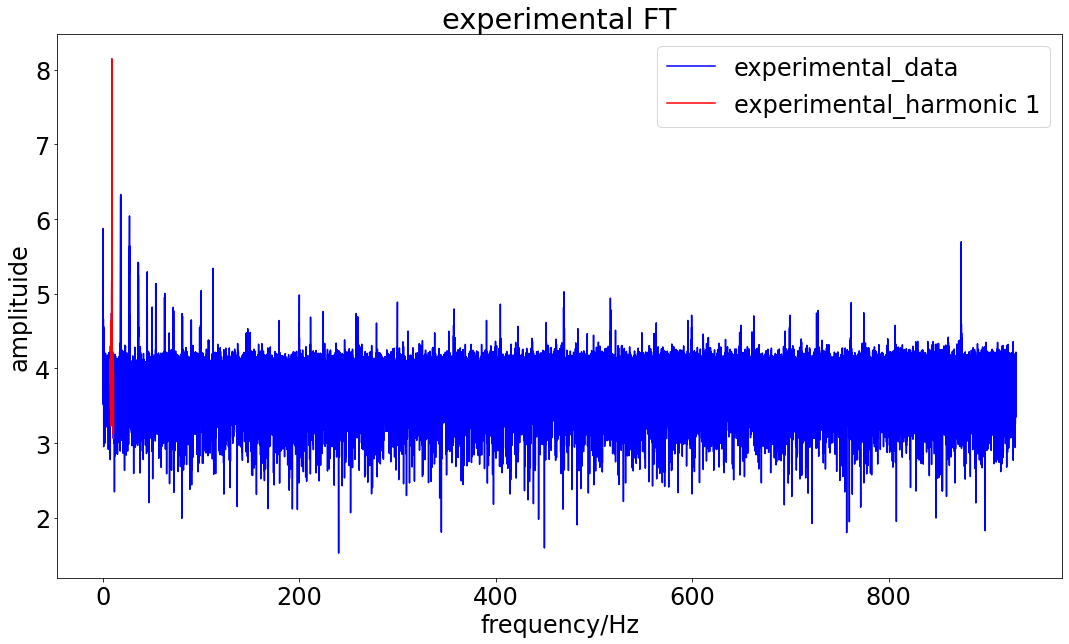

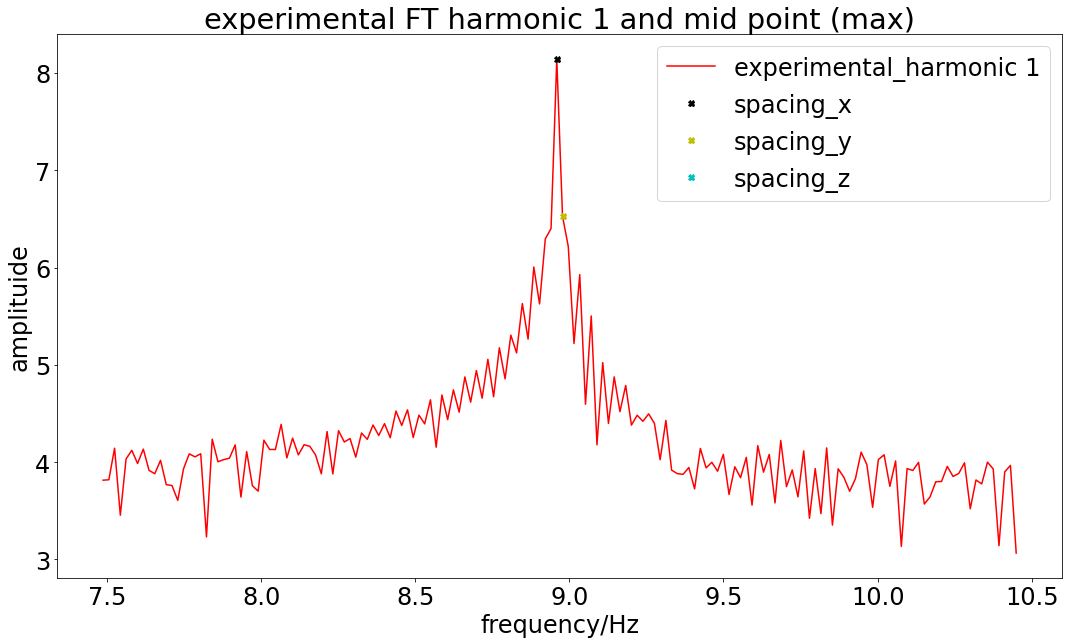

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (4,)
dims[0]:  4


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.    -0.53  -0.314  0.   ]
upper_bounds:  [ 4.00e+03 -1.70e-01  3.14e-01  1.00e+01]
random starting points:  [ 3.86252995e+03 -4.17978699e-01  1.92435408e-01  1.63713203e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      2549642    0:07.8
1     8      2549642    0:07.8
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 3.86252995e+03 -4.17978699e-01  1.92435408e-01  1.63713203e+00]
         Found solution: 
 3.89441637926020621e+03  :kappa0_1
-4.35911782985658747e-01  :epsilon0_1
 1.78870750251205579e-01  :mew
 1.36383231521130988e+00  :zeta
lower_bounds:  [ 0.    -0.53  -0.314  0.   ]
upper_bounds: 

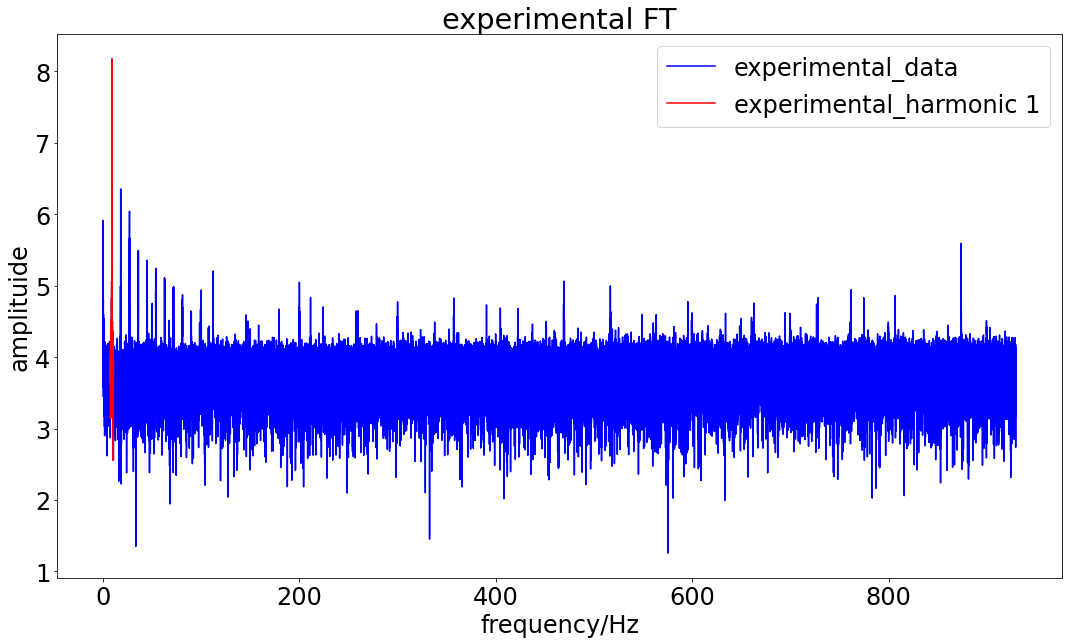

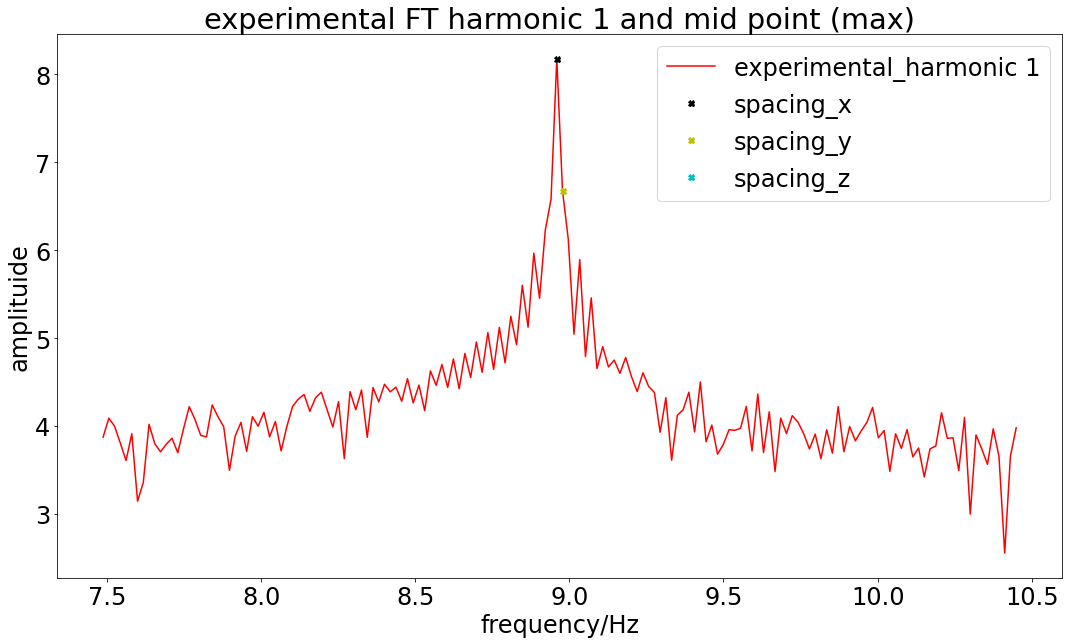

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (4,)
dims[0]:  4


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.    -0.58  -0.314  0.   ]
upper_bounds:  [ 4.00e+03 -2.20e-01  3.14e-01  1.00e+01]
random starting points:  [ 6.44079029e+02 -4.85972404e-01 -8.81300702e-02  4.19418716e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      6489310    0:00.5
1     8      6489310    0:00.5
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 6.44079029e+02 -4.85972404e-01 -8.81300702e-02  4.19418716e+00]
         Found solution: 
 7.11343402218525512e+02  :kappa0_1
-4.84063928833866064e-01  :epsilon0_1
-7.58533380191698525e-02  :mew
 3.67935031174354288e+00  :zeta
lower_bounds:  [ 0.    -0.58  -0.314  0.   ]
upper_bounds: 

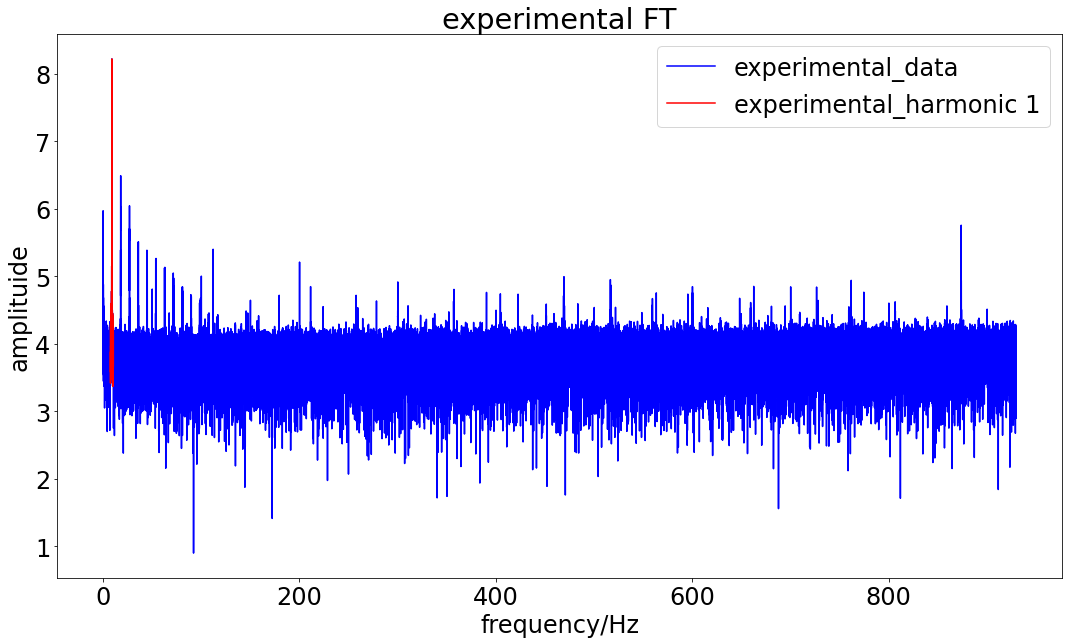

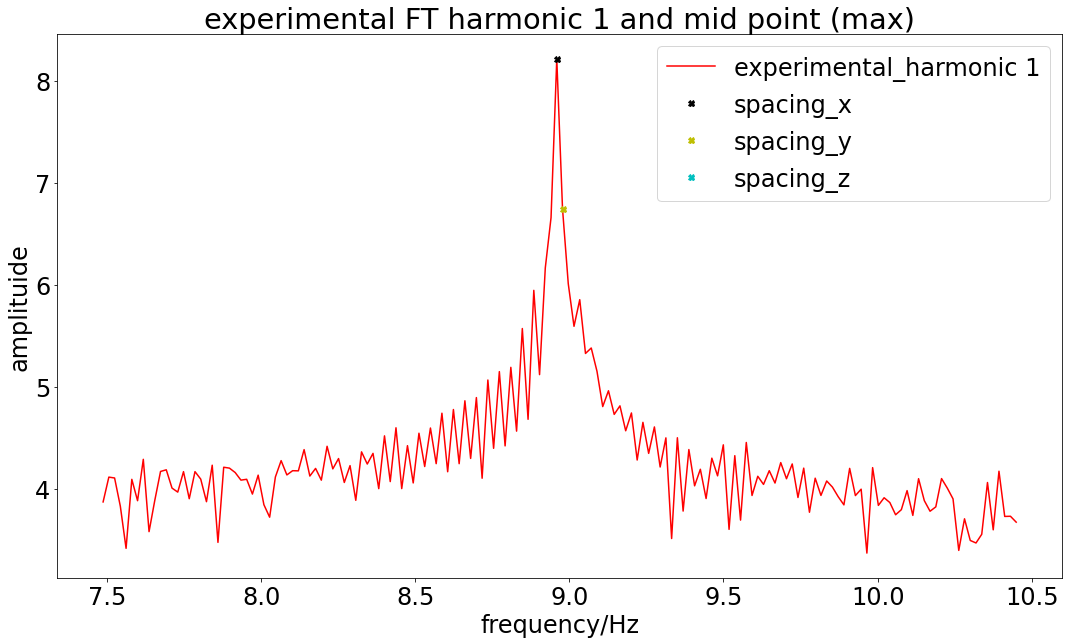

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (4,)
dims[0]:  4


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.    -0.63  -0.314  0.   ]
upper_bounds:  [ 4.00e+03 -2.70e-01  3.14e-01  1.00e+01]
random starting points:  [ 2.28252409e+03 -4.52246584e-01 -2.98519423e-01  2.59848893e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      4028839    0:00.5
1     8      4028839    0:00.5
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 2.28252409e+03 -4.52246584e-01 -2.98519423e-01  2.59848893e+00]
         Found solution: 
 2.28925073430487919e+03  :kappa0_1
-4.52792952857098308e-01  :epsilon0_1
-2.98422592819111265e-01  :mew
 2.57487432692846063e+00  :zeta
lower_bounds:  [ 0.    -0.63  -0.314  0.   ]
upper_bounds: 

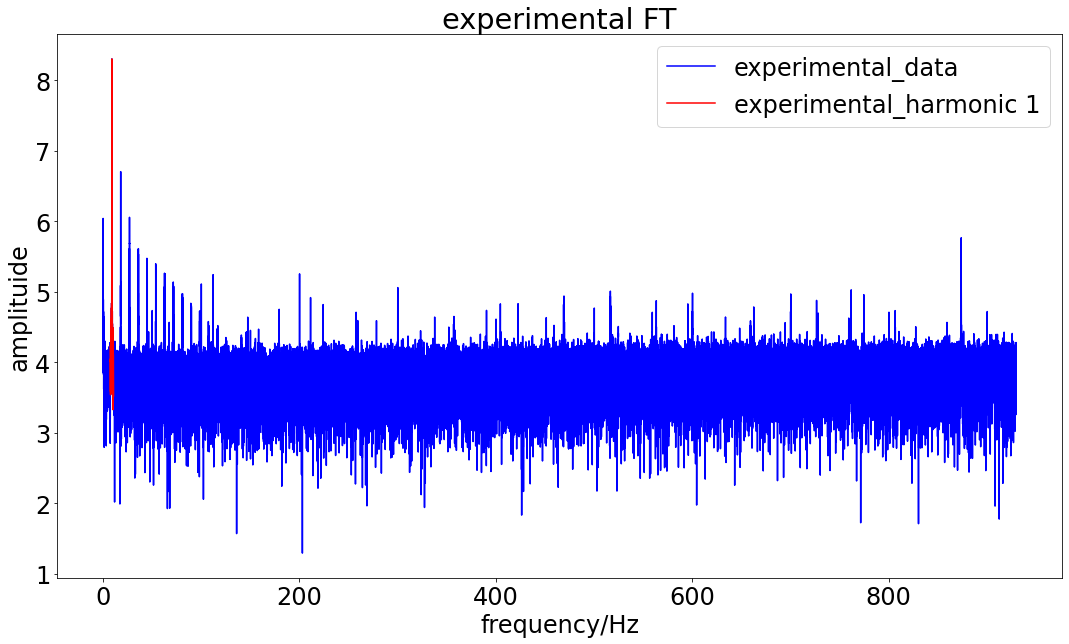

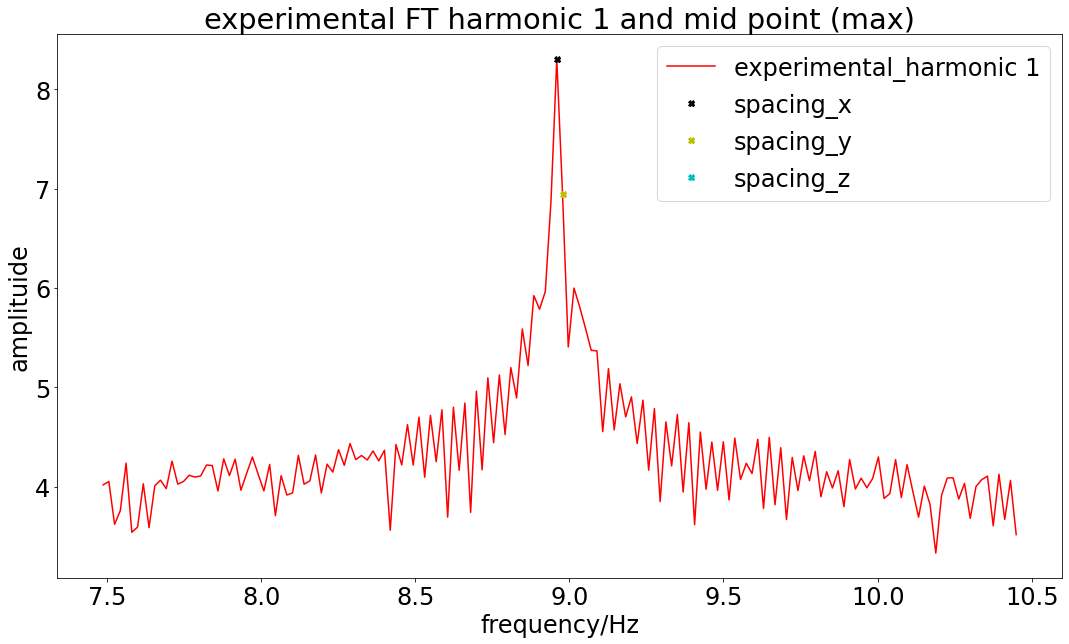

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (4,)
dims[0]:  4


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.    -0.68  -0.314  0.   ]
upper_bounds:  [ 4.00e+03 -3.20e-01  3.14e-01  1.00e+01]
random starting points:  [ 1.52449769e+03 -6.48837602e-01  1.89314692e-01  9.88240594e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      1.38e+07   0:00.6
1     8      1.38e+07   0:00.6
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 1.52449769e+03 -6.48837602e-01  1.89314692e-01  9.88240594e+00]
         Found solution: 
 1.57103097260665868e+03  :kappa0_1
-6.45959772977224955e-01  :epsilon0_1
 2.23489186822983965e-01  :mew
 9.87226644623893179e+00  :zeta
lower_bounds:  [ 0.    -0.68  -0.314  0.   ]
upper_bounds: 

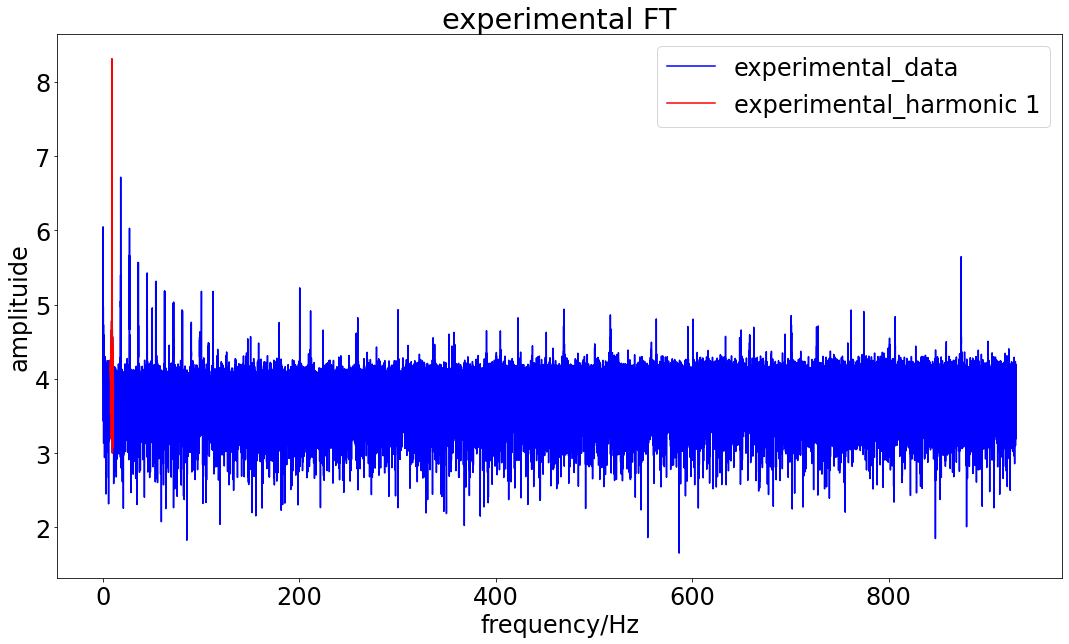

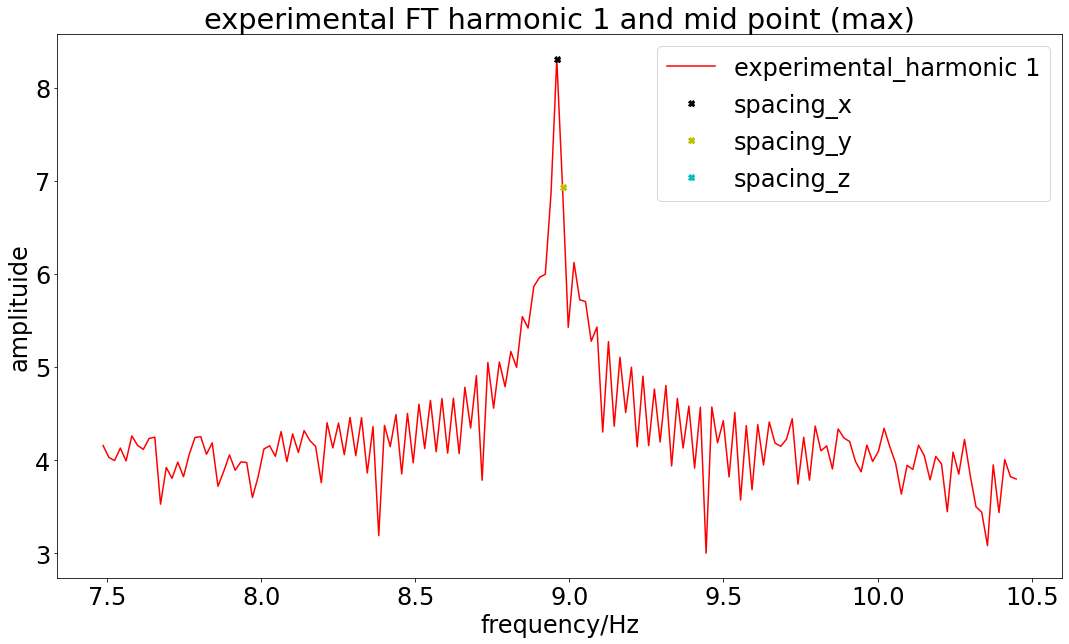

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (4,)
dims[0]:  4


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.    -0.73  -0.314  0.   ]
upper_bounds:  [ 4.00e+03 -3.70e-01  3.14e-01  1.00e+01]
random starting points:  [ 4.15360843e+02 -4.10726664e-01  4.57788292e-02  9.46566688e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      1.22e+07   0:00.4
1     8      1.22e+07   0:00.4
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 4.15360843e+02 -4.10726664e-01  4.57788292e-02  9.46566688e+00]
         Found solution: 
 3.41176954121494134e+02  :kappa0_1
-4.11933730173244250e-01  :epsilon0_1
 2.37424584522024085e-02  :mew
 9.43190764613681942e+00  :zeta
lower_bounds:  [ 0.    -0.73  -0.314  0.   ]
upper_bounds: 

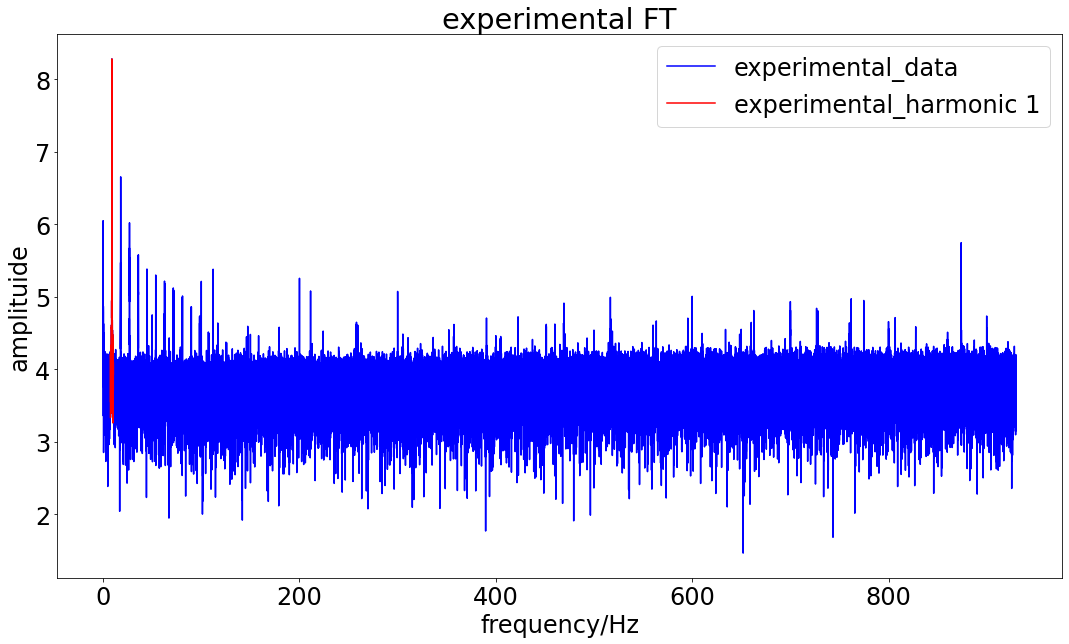

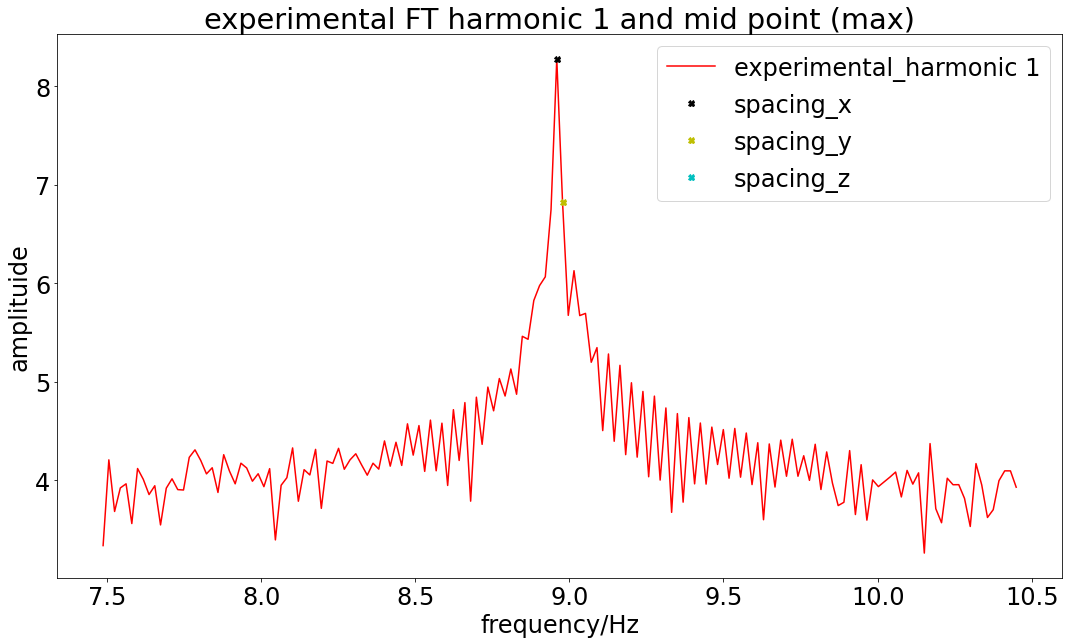

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (4,)
dims[0]:  4


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.    -0.78  -0.314  0.   ]
upper_bounds:  [ 4.00e+03 -4.20e-01  3.14e-01  1.00e+01]
random starting points:  [ 3.96648207e+03 -5.09582447e-01  8.02627791e-02  6.38644765e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      9312104    0:00.5
1     8      9312104    0:00.5
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 3.96648207e+03 -5.09582447e-01  8.02627791e-02  6.38644765e+00]
         Found solution: 
 3.97015073420589715e+03  :kappa0_1
-5.20132802922280035e-01  :epsilon0_1
 9.07461031278690711e-02  :mew
 5.77838268561492985e+00  :zeta
lower_bounds:  [ 0.    -0.78  -0.314  0.   ]
upper_bounds: 

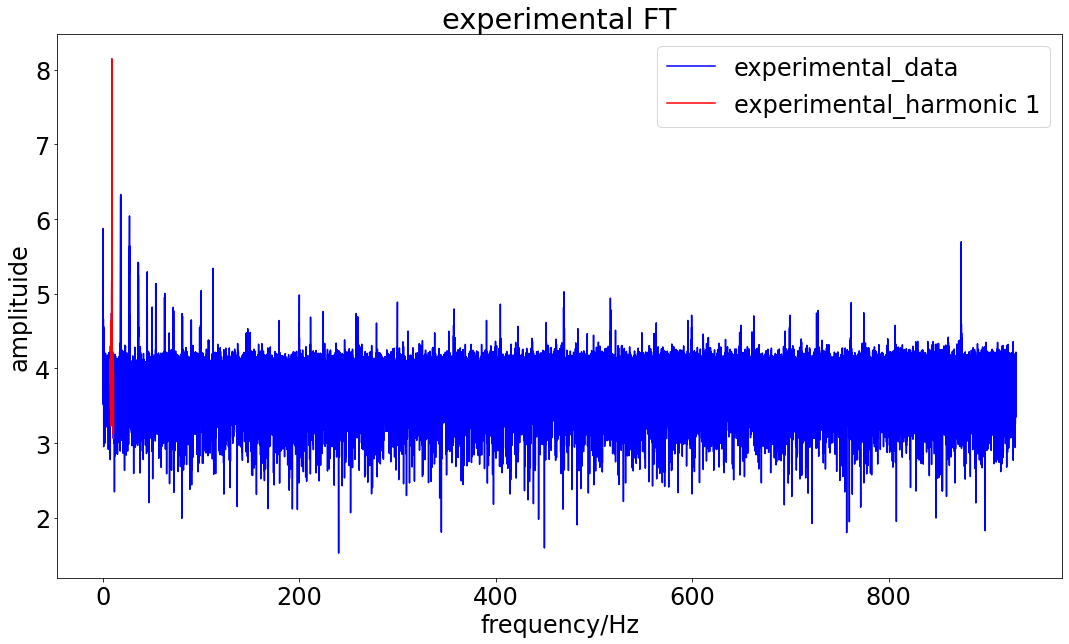

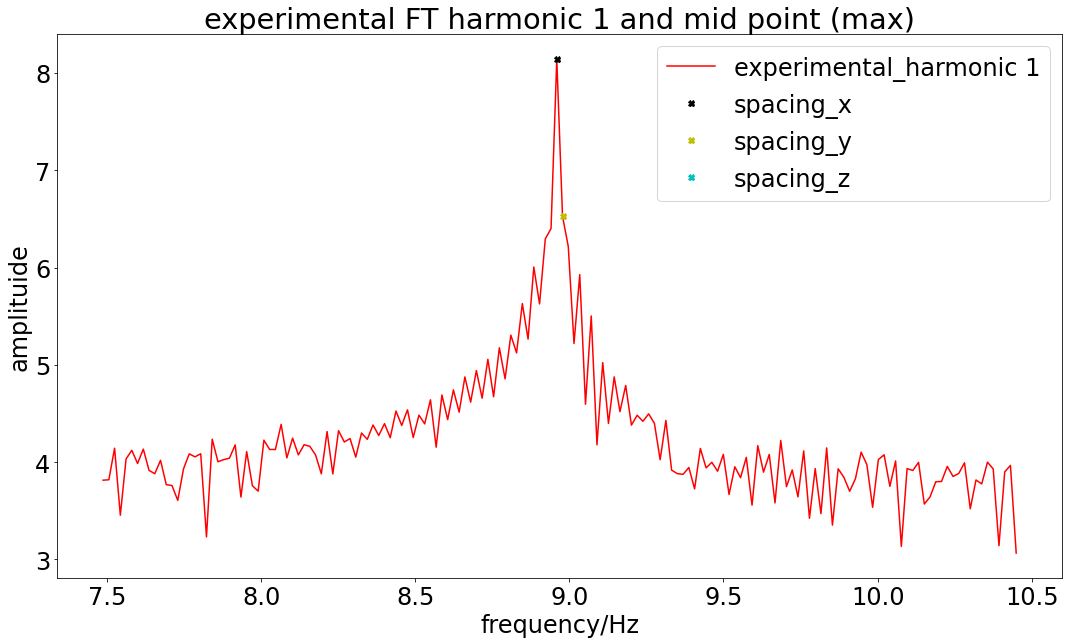

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.53  -0.53  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -1.70e-01 -1.70e-01  3.14e-01  1.00e+01]
random starting points:  [ 7.28143811e+02  6.77479715e+02 -3.86062008e-01 -2.72627203e-01
 -1.69385924e-01  1.20599502e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      3332730    0:14.8
1     9      3332730    0:14.8
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 7.28143811e+02  6.77479715e+02 -3.86062008e-01 -2.72627203e-01
 -1.69385924e-01  1.20599502e+00]
         Found solution: 
 8.11906664411779389e+02  :kappa0_1
 5.25183225674860523e+02  :kappa0_2
-4.02785780067289267e-01

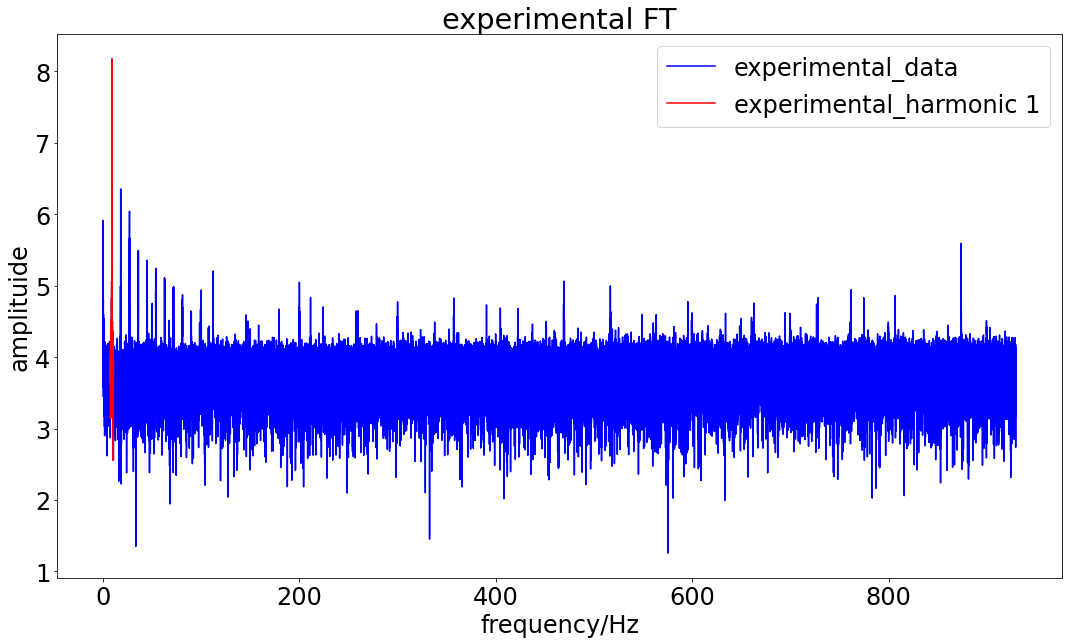

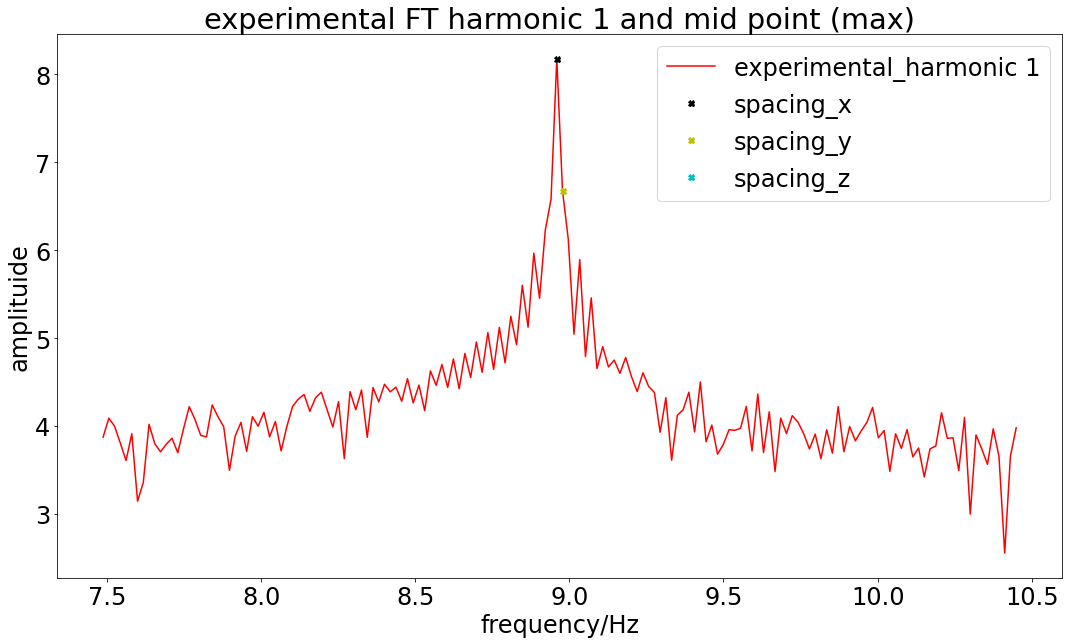

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.58  -0.58  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -2.20e-01 -2.20e-01  3.14e-01  1.00e+01]
random starting points:  [ 3.03759210e+03  3.95360143e+03 -4.59439148e-01 -3.82193220e-01
 -1.30746766e-01  4.02517070e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      1.1e+07    0:01.0
1     9      1.1e+07    0:01.0
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 3.03759210e+03  3.95360143e+03 -4.59439148e-01 -3.82193220e-01
 -1.30746766e-01  4.02517070e+00]
         Found solution: 
 2.97831513738533795e+03  :kappa0_1
 3.94805389765595964e+03  :kappa0_2
-4.57098064748679200e-01

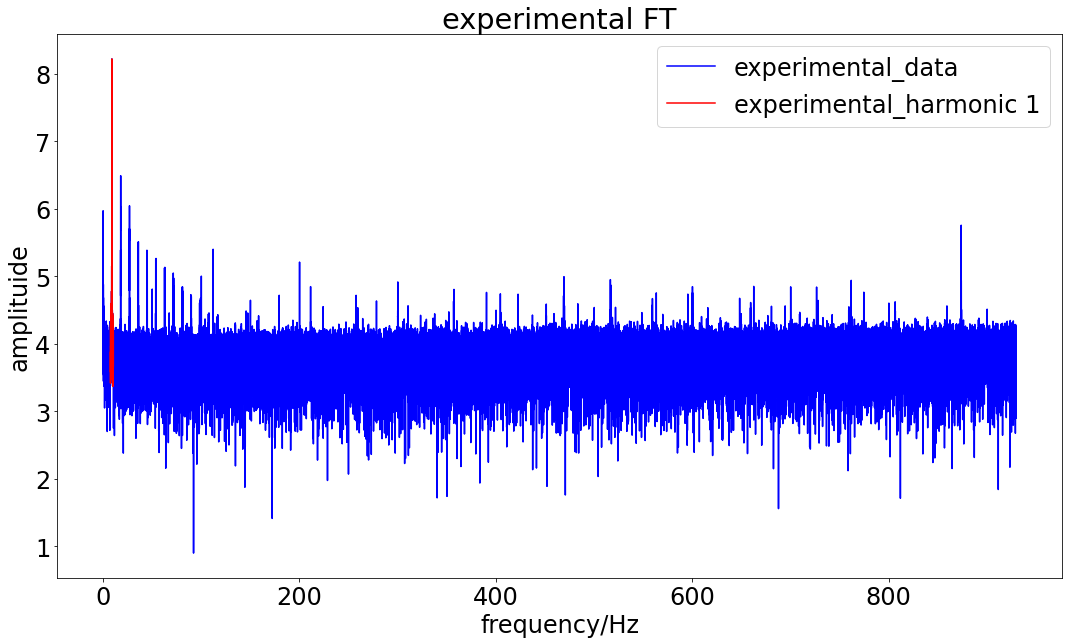

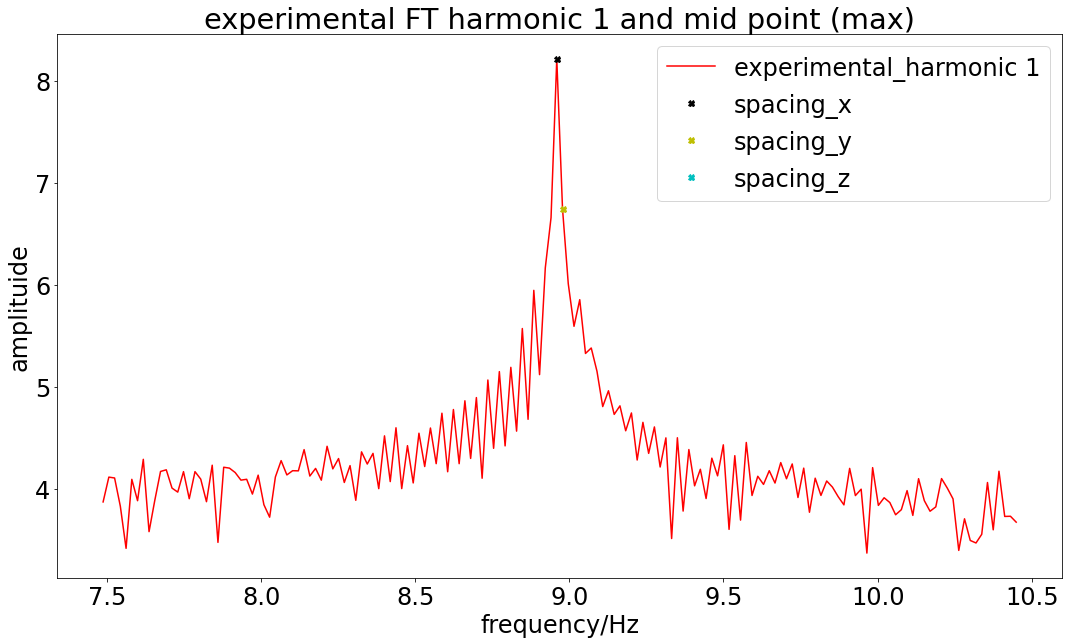

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.63  -0.63  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -2.70e-01 -2.70e-01  3.14e-01  1.00e+01]
random starting points:  [ 1.23511760e+03  3.45416199e+03 -4.89522647e-01 -5.88580190e-01
  2.50519780e-01  6.49346717e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      4431896    0:01.0
1     9      4431896    0:01.0
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 1.23511760e+03  3.45416199e+03 -4.89522647e-01 -5.88580190e-01
  2.50519780e-01  6.49346717e+00]
         Found solution: 
 1.17483463278532304e+03  :kappa0_1
 3.53429028474601910e+03  :kappa0_2
-5.05693650054277577e-01

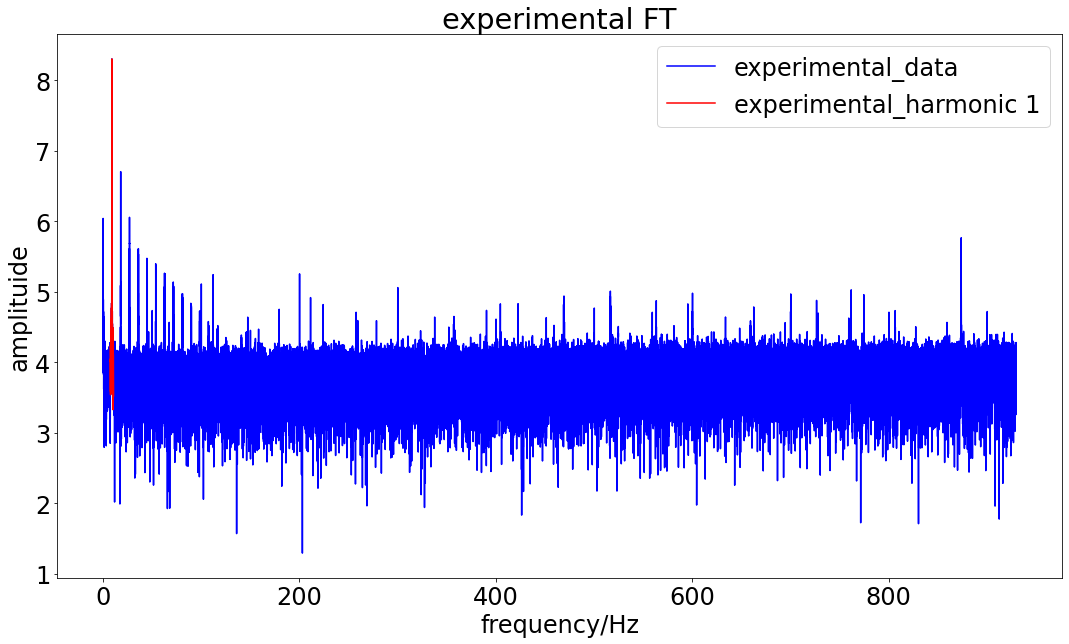

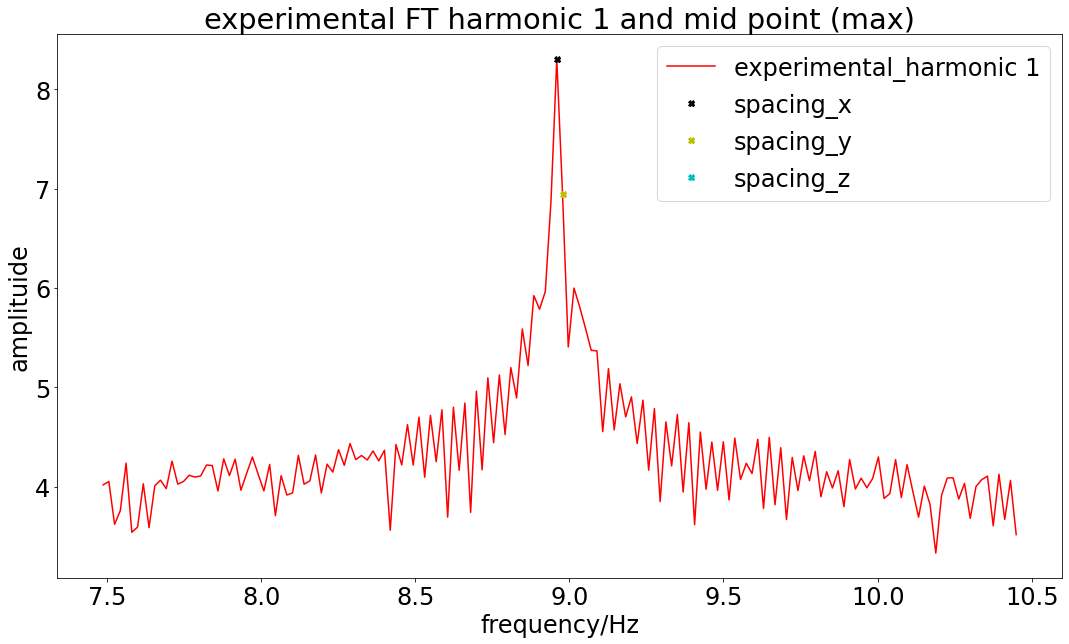

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.68  -0.68  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -3.20e-01 -3.20e-01  3.14e-01  1.00e+01]
random starting points:  [ 6.93649784e+02  1.89244438e+03 -5.34076116e-01 -5.82191511e-01
 -8.98209617e-04  2.51183727e-01]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      1770023    0:00.9
1     9      1770023    0:00.9
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 6.93649784e+02  1.89244438e+03 -5.34076116e-01 -5.82191511e-01
 -8.98209617e-04  2.51183727e-01]
         Found solution: 
 6.93705585348970772e+02  :kappa0_1
 1.89043261029694304e+03  :kappa0_2
-5.33816180562541431e-01

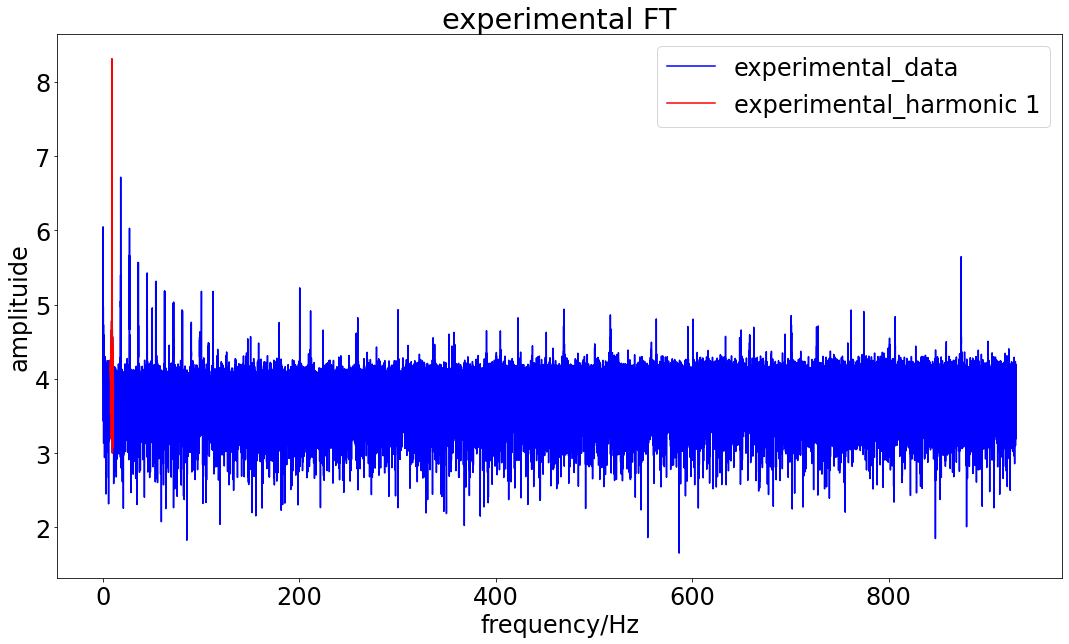

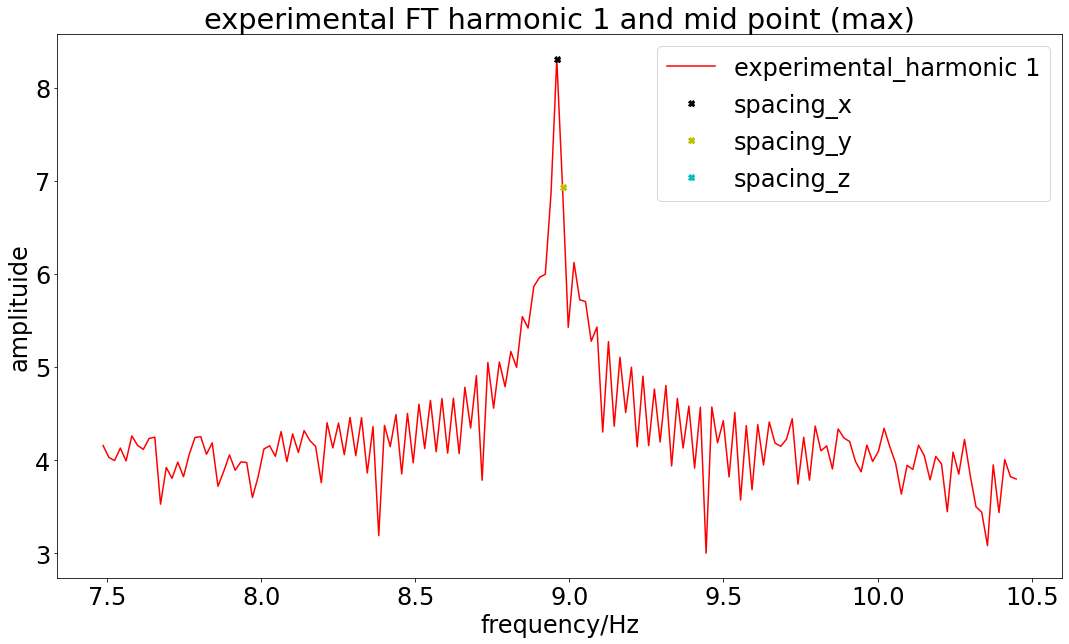

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.73  -0.73  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -3.70e-01 -3.70e-01  3.14e-01  1.00e+01]
random starting points:  [ 1.87293107e+03  5.57379223e+01 -6.80502509e-01 -6.16122872e-01
  2.12937459e-01  2.90190010e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      2951265    0:01.0
1     9      2951265    0:01.0
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 1.87293107e+03  5.57379223e+01 -6.80502509e-01 -6.16122872e-01
  2.12937459e-01  2.90190010e+00]
         Found solution: 
 1.83691642789514594e+03  :kappa0_1
 5.37299470197248397e+01  :kappa0_2
-6.82065516899366786e-01

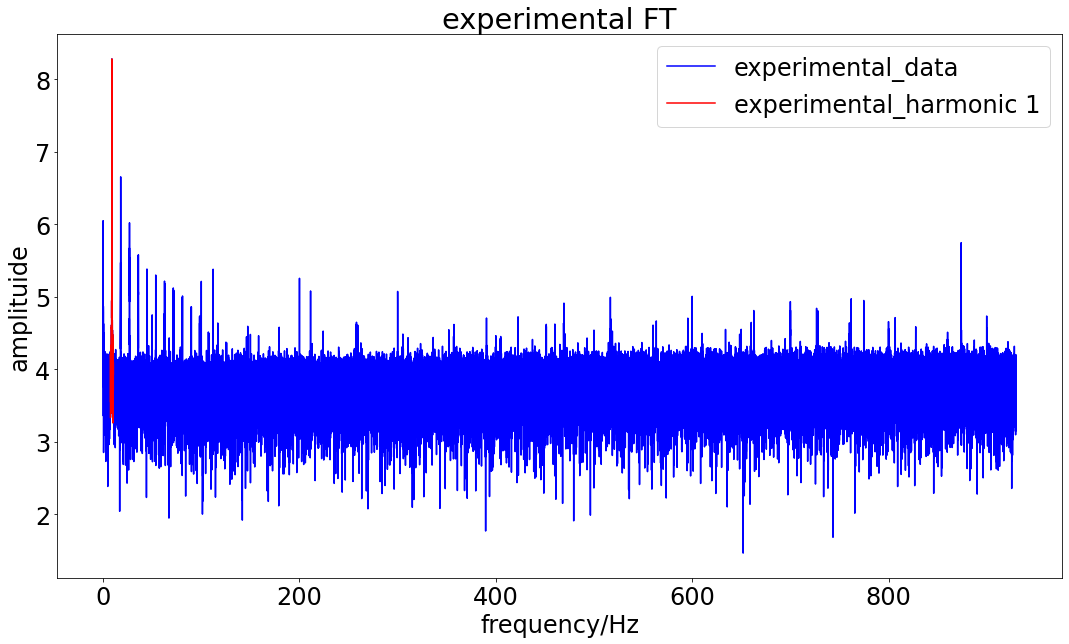

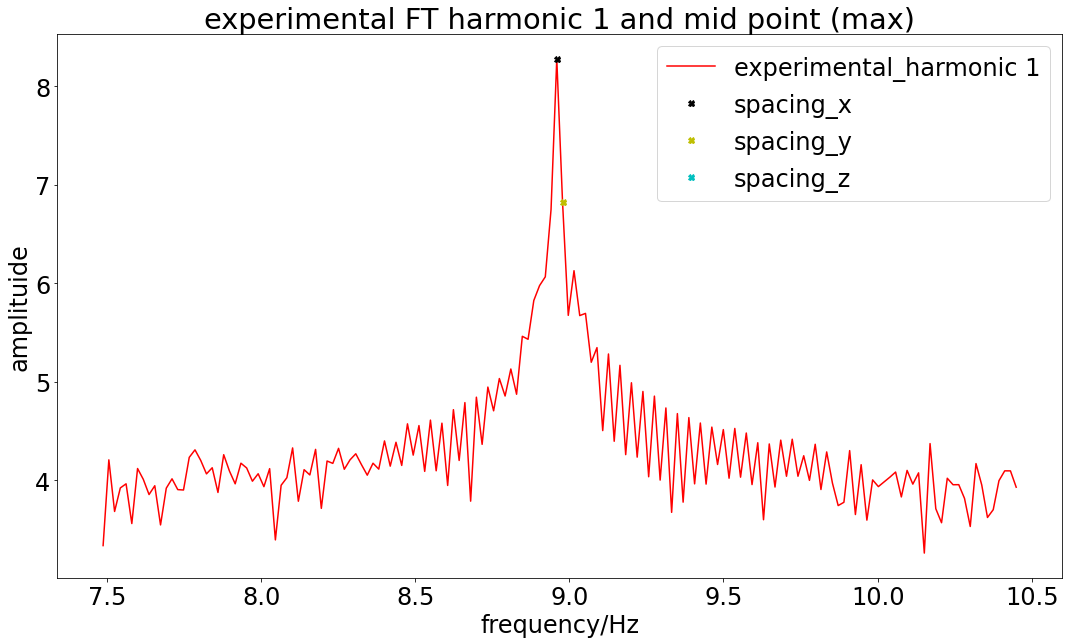

harmonic_spacing (480):  481
mid_point_index (89):  177
index_window (32):  24
dims:  (6,)
dims[0]:  6


**************************************** Run:  0  ****************************************


lower_bounds:  [ 0.     0.    -0.78  -0.78  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -4.20e-01 -4.20e-01  3.14e-01  1.00e+01]
random starting points:  [ 2.21181197e+03  3.93304215e+03 -5.35667508e-01 -7.76117910e-01
  2.30687657e-01  4.71337973e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      4218791    0:01.1
1     9      4218791    0:01.1
Halting: Maximum number of iterations (1) reached.
random starting points:  [ 2.21181197e+03  3.93304215e+03 -5.35667508e-01 -7.76117910e-01
  2.30687657e-01  4.71337973e+00]
         Found solution: 
 2.18619422944252165e+03  :kappa0_1
 3.93056273408759398e+03  :kappa0_2
-5.39153983675188297e-01

In [8]:
 %%time

for steps in range(2):
    for index in range(6):
        # specifing files and model 
        # specifing data location and folder for outputs

        Phfolder = ['ph4 2m nacl 25oC','ph5 2m nacl 25oC','ph6 2m nacl 25oC','ph7 2m nacl 25oC','ph8 2m nacl 25oC','ph9 2m nacl 25oC']

        data_file_names = ['9_2b_cv_current_reduced_0', '9 150_2_cv_current_reduced_0',
                        '9 150_2_cv_current_reduced_0', '9 150_2_cv_current_reduced_0',
                        '9 150_2_cv_current_reduced_0', '9 150_2_cv_current_reduced_0']

        experiment_folder = ['9_2b', '9 150_2',
                            '9 150_2', '9 150_2',
                            '9 150_2', '9 150_2']


        startPotential_list = [-50.0E-3, -100.0E-3, -150.0E-3, -200.0E-3, -250.0E-3, -300.0E-3]
        revPotential_list = [-650.0E-3, -700.0E-3, -750.0E-3, -800.0E-3, -850.0E-3, -900.0E-3]
        uncomp_resis_list = [1.47088296400589904e+01, 2.21591576942530040e+01, 4.91093353554637702e+01, 9.88664261322310978e+01, 1.17141484934528876e+02, 7.05892919782000945e+01]

        cap_params_list = [[1.88356617040317533e-04,  1.61804365758608931e-04,  4.17733352175351375e-04,  2.26950951952747818e-04,
                            1.89087024301737571e-04,  1.73822413041256054e-04,  4.40681837479345263e-04,  2.44766708609961067e-04,
                            5.62930605709615577e+01],

                            [2.01046157685056092e-04,  1.65326019926110603e-04,  4.01459877636903099e-04,  2.00358613097372006e-04,
                            2.03045919581428289e-04,  1.85822674885049088e-04,  4.39025102071718271e-04,  2.26832627779461607e-04,
                            5.62930598096524619e+01],

                            [2.16710589150491796e-04,  1.18587321543490044e-04,  2.52608818706907693e-04,  7.92142685465222363e-05,
                            2.19857072436029322e-04,  1.42935910235657748e-04,  2.93898865610105415e-04,  1.06914227013806895e-04,
                            5.62930603148108872e+01],

                            [2.44250821702577889e-04,  6.11686980351668942e-05,  1.93117706816158582e-04,  4.98780068059828056e-05,
                            2.48408084782024917e-04,  8.53541742949904918e-05,  2.27631358189466209e-04,  7.04358854650487080e-05,
                            5.62930679816280701e+01],

                            [2.31361615205293226e-04, -4.48805198759543150e-05, -3.17426618710159704e-05, -8.10905235716404948e-05,
                            2.37894833041238580e-04, -1.24228492436435044e-05,  1.25450098938867990e-05, -5.71843941930220284e-05,
                            5.62930702346411920e+01],
                            
                            [2.02672430954748301e-04, -1.43761431754603811e-04, -2.41139519986166453e-04, -1.87439676849578303e-04,
                            2.14689924822296846e-04, -8.42761165101093852e-05, -1.55376757682682692e-04, -1.43409166610797040e-04,
                            5.62930663096474433e+01]
                            ]
        
        initalDiscard_list = [0.035, 0.035, 0.035, 0.035, 0.035, 0.035]
        endDiscard_lst = [0.880, 0.880, 0.880, 0.880, 0.880, 0.880]
        # know paramteres for 9 150_1_cv_current_reduced_2
        freq_list= np.asarray([8.977950e+00, 8.977950e+00 , 8.977950e+00, 8.977950e+00, 8.977950e+00, 8.977950e+00])
        rateOfPotentialChange = -22.35174e-3

        deltaepislon = 150.0E-3
        electrode_area = 0.03
        electode_coverage = 6.5e-12


        Hz_interval_fitting_interval = freq_list*0.05

        adjustment = [-1, -1, -1, -1, -1, -1]
        fourthAdjustment = [-4, -4, -4, -4, -4, -4]

        data_name = data_file_names[index]
        file_name = data_name + '.txt'
        folder = os.path.join('Data', 'processed')
        folder = os.path.join(folder, '220415')
        folder = os.path.join(folder, Phfolder[index])
        folder = os.path.join(folder, 'ac')
        folder = os.path.join(folder, experiment_folder[index])
        data_file = os.path.join(folder, 'experimental')
        data_file = os.path.join(data_file, file_name)

        # creating file for output
        fitting_technique = 'harmonic '
        output_file_name = fitting_technique + 'fitting_for_faradaic_data'
        output_file_name = output_file_name + '.txt'
        folder = os.path.join(folder, 'faradaic_fitting')
        if steps == 0:
            folder = os.path.join(folder, 'oneStepModel')
        if steps == 1:
            folder = os.path.join(folder, 'twoStepModel')
        f= open(os.path.join( folder, output_file_name),"w")

        # opening data
        experimental_data = pd.read_csv(data_file, sep='\t')

        exp_times = np.asarray(experimental_data.time)
        exp_current = np.asarray(experimental_data.current)

        # know paramteres that are data specific
        inital_current = exp_current[index]
        startPotential= startPotential_list[index]
        revPotential = revPotential_list[index]
        uncomp_resis = uncomp_resis_list[index]

        # delacring capactiance parameters
        # (gamma0, gamma1, gamma2, gamma3, omega)
        cap_params = cap_params_list[index][:]

        measurements = exp_current.shape[0]
        # print('measurements: ', measurements)
        # if measurements%2 !=0:
        #     print('*'*30+'\nerror must have evennumber of measurments\n'+'*'*40)

        # declaring model to obtain non dimensinalise constant
        if steps == 0:
            trial = oneStepModel(timeStepSize=exp_times[1], inital_current=inital_current, freq=freq_list[index], startPotential= startPotential,
                                    revPotential = revPotential, rateOfPotentialChange = rateOfPotentialChange, numberOfMeasurements = measurements,
                                    deltaepislon=deltaepislon, uncomp_resis=uncomp_resis, electrode_area=electrode_area, 
                                    electode_coverage=electode_coverage)
        if steps == 1:
            trial = newtonRaphsonFT(timeStepSize=exp_times[1], inital_current=inital_current, freq=freq_list[index], startPotential= startPotential,
                                    revPotential = revPotential, rateOfPotentialChange = rateOfPotentialChange, numberOfMeasurements = measurements,
                                    deltaepislon=deltaepislon, uncomp_resis=uncomp_resis, electrode_area=electrode_area, 
                                    electode_coverage=electode_coverage)

        
        # non-diming experimental data
        exp_current_dimless = exp_current/trial.I0

        # model for optimsation
        if steps == 0:
            model = wrappedOneStepModel(times = exp_times, inital_current=inital_current, freq=freq_list[index], startPotential= startPotential,
                                revPotential = revPotential, rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon,
                                uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage,
                                initaldiscard = initalDiscard_list[index], enddiscard = endDiscard_lst[index], cap_params=cap_params)
        if steps == 1:
            model = wrappedNewton(times = exp_times, inital_current=inital_current, freq=freq_list[index], startPotential= startPotential,
                                revPotential = revPotential, rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon,
                                uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage,
                                initaldiscard = initalDiscard_list[index], enddiscard = endDiscard_lst[index], cap_params=cap_params)

        real_parameters = model.suggested_parameter()
        if steps == 0:
            parameter_order = ['kappa0_1', 'epsilon0_1', 'mew', 'zeta']
        if steps == 1:
            parameter_order = ['kappa0_1', 'kappa0_2', 'epsilon0_1', 'epsilon0_2', 'mew', 'zeta']

        real_parameters = np.asarray(model.suggested_parameter())
        f.write("experimental data: " + data_file + "\r\n")
        print('experimental data: ',data_file)

        # checking loaction of harmonics 1-4
        half_of_measuremnts = int(measurements/2)

        # full FT and frequencies
        full_sim = np.fft.fft(exp_current_dimless)
        half_full_sim = full_sim[:half_of_measuremnts]

        freq_org = np.fft.fftfreq(exp_times.shape[-1], d= exp_times[1])
        freq_org=freq_org[:half_of_measuremnts]

        # regional FT and Frequency

        freq = model.frequencies_for_harmonics_4_to_12(exp_times)

        harmonics1To4 = model.FT_and_reduce_to_harmonics_4_to_12(exp_current_dimless)

        xaxislabel = "frequency/Hz" # "potential/V"
        plt.figure(figsize=(18,10))
        plt.title("experimental FT")
        plt.ylabel("amplituide")
        plt.xlabel(xaxislabel)
        plt.plot(freq_org, np.log10(half_full_sim),'b', label='experimental_data')
        plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
        plt.legend(loc='best')
        plt.savefig(os.path.join( folder, 'experiment FT data and range 4-12.pdf'))
        plt.close()

        xaxislabel = "frequency/Hz" # "potential/V"
        plt.figure(figsize=(18,10))
        plt.title("experimental harmonics 1 -4 ")
        plt.ylabel("amplituide")
        plt.xlabel(xaxislabel)
        plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
        plt.legend(loc='best')
        plt.savefig(os.path.join( folder, 'experiment FT harmonics 4-12.pdf'))
        plt.close()

        # declaring problem

        problem = pints.SingleOutputProblem(model, exp_times, exp_current_dimless)

        score = ComplexRootMeanSquaredError_harmonics(problem, model, Hz_interval=Hz_interval_fitting_interval[index], times=exp_times, adjustment = adjustment[index], fourthAdjustment = fourthAdjustment[index])

        e_min = model.startPotential + 0.2*(model.revPotential - model.startPotential)
        e_max = model.startPotential + 0.8*(model.revPotential - model.startPotential)

        if steps == 0:
            lower_bounds = np.asarray([0.0, e_max, -0.314, 0.0])#, 0.1])
            upper_bounds = np.asarray([4000.0, e_min, 0.314, 10])#, 4.5])
        if steps == 1:
            lower_bounds = np.asarray([0.0, 0.0, e_max, e_max, -0.314, 0.0])#, 0.1])
            upper_bounds = np.asarray([4000.0, 4000.0, e_min, e_min, 0.314, 10])#, 4.5])

        boundaries = pints.RectangularBoundaries(lower_bounds, upper_bounds)

        # optimisimg
        total_runs = 10
        dims = real_parameters.shape
        print('dims: ', dims)
        print('dims[0]: ', dims[0])
        params_matrix = np.zeros((total_runs, dims[0]))
        for run in range(total_runs):
                
            if run > 0:
                f = open(os.path.join( folder, output_file_name),"a")

            f.write("\r\n\r\n" + 40*"*" + " Run: %d " % run + 40*"*" + "\r\n\r\n")
            print('\n\n' + 40*"*" + ' Run: ', run, ' ' + 40*"*" + '\n\n')
            accuracy = (2 + run)
            # f.write("Threshold for stopping: %e\r\n\r\n" % pow(10,-accuracy))
            # print('Threshold for stopping: ', pow(10,-accuracy))

            ranges = upper_bounds - lower_bounds 

            starting_points = np.copy(lower_bounds)
            for i in range(len(ranges)):
                starting_points[i] += ranges[i] * np.random.uniform(low = 0.001, high = 0.999)
            
            print('lower_bounds: ', lower_bounds)
            print('upper_bounds: ', upper_bounds)

            print('random starting points: ', starting_points)

            f.write("lower_bounds: ")
            for i in lower_bounds:
                f.write("%e, " % i)
            f.write("\r\nupper_bounds: ")
            for i in upper_bounds:
                f.write("%e, " % i)
            f.write("\r\nRandom starting_points: ")
            for i in starting_points:
                f.write("%e, " % i)
            f.write("\r\n")

            # transformation
            transform = pints.RectangularBoundariesTransformation(boundaries)

            # optimising boundaries=boundaries,
            opt = pints.OptimisationController(
                score,
                x0=starting_points,
                method=pints.CMAES,
                transform = transform)

                
            #opt.set_max_unchanged_iterations(iterations=50, threshold=pow(10,-accuracy))
            #opt.set_max_unchanged_iterations(iterations=100)
            opt.set_parallel(parallel=True)
            # opt.set_max_iterations(iterations=1)
            opt.set_log_interval(iters=20, warm_up=3)
            #opt.set_threshold(threshold=-??????)
            
            found_parameters, found_value =  opt.run()
                #CMAES, PSO, SNES, XNES
            # output results

            print('random starting points: ', starting_points)

            f.write("Found solution: ")
            for k, x in enumerate(found_parameters):
                f.write(pints.strfloat(x) +", ")

            print('         Found solution: ')
            name = 0
            for k, x in enumerate(found_parameters):
                print( pints.strfloat(x) +'  :' + parameter_order[name])
                name = name + 1

            print('lower_bounds: ', lower_bounds)
            print('upper_bounds: ', upper_bounds)

            f.write("\r\n\r\nFound solution:\r\n")
            name = 0
            for k, x in enumerate(found_parameters):
                f.write(pints.strfloat(x) + '  :' + parameter_order[name]+ '\r\n')
                name = name + 1

            params_matrix[run, :] = found_parameters

            # plotting current for found parameters over the experimentally data

            xaxis = exp_times #model.potentialRange
            xaxislabel = "time/s" # "potential/V"
            solution = model.simulate(found_parameters, exp_times)


            plt.figure(figsize=(18,10))
            plt.title("optimised and experimental values")
            plt.ylabel("Fourier transformed current/dimless")
            plt.xlabel(xaxislabel)
            plt.plot(xaxis, exp_current_dimless,'r', label='experiment')
            plt.plot(xaxis ,solution,'b', label='optimised_'+str(found_parameters[0])+'_'+str(found_parameters[1]))
            plt.legend(loc='best')
            plt.savefig(os.path.join( folder, 'experiment against optimised with potential run '+str(run)+'.pdf'))
            #plt.show()
            plt.close()
            
            found_score = score(found_parameters)
            print("Score at found solution:", found_score)
            f.write("Score at found solution: %.16e\r\n" % found_score)

            run += run
        f.close()